In [6]:
%matplotlib inline
import gym
import matplotlib.pyplot as plot
import numpy as np
import random
import seaborn as sns
plot.style.use('ggplot')

## Value iteration:

In [2]:
env = gym.make('FrozenLake-v0')

In [3]:
print (env.observation_space.n, env.action_space.n)

value_table = np.zeros(env.observation_space.n)

for _ in range(10000):
    updated_value_table = np.copy(value_table)
    for state in range(env.observation_space.n):
        Q_value = []
        for action in range(env.action_space.n):
            next_states_rewards = []
            for next_sr in env.P[state][action]:
                trans_prob, next_state, reward_prob, _ = next_sr
                next_states_rewards.append((trans_prob * (reward_prob + 0.99 * updated_value_table[next_state])))
            Q_value.append(np.sum(next_states_rewards))
        value_table[state] = max(Q_value)
    if np.sum(np.fabs(updated_value_table - value_table)) < 1e-8:
        print('converged')
        break

print('value_table', value_table)

policy = np.zeros(env.observation_space.n)
for state in range(env.observation_space.n):
    Q_table = np.zeros(env.action_space.n)
    for action in range(env.action_space.n):
        for next_sr in env.P[state][action]:
            trans_prob, next_state, reward_prob, _ = next_sr
            Q_table[action] += trans_prob * (reward_prob + 0.99 * value_table[next_state])
    policy[state] = np.argmax(Q_table)
print('policy', policy)

16 4
converged
value_table [0.5420259  0.49880315 0.47069564 0.45685165 0.55845093 0.
 0.35834805 0.         0.59179872 0.64307981 0.61520754 0.
 0.         0.74172043 0.86283742 0.        ]
policy [0. 3. 3. 3. 0. 0. 0. 0. 3. 1. 0. 0. 0. 2. 1. 0.]


## Q-learning

In [4]:
env = gym.make('Taxi-v2')

In [5]:
env.observation_space, env.action_space

(Discrete(500), Discrete(6))

In [11]:
def wmean(a, n):
    s = np.cumsum(a)
    return np.concatenate([a[:n], (s[n:] - s[:-n]) / n])

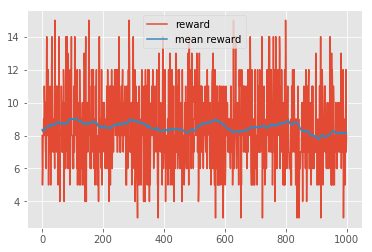

CPU times: user 10.7 s, sys: 137 ms, total: 10.8 s
Wall time: 10.8 s


In [24]:
%%time
Q = np.random.random_sample((env.observation_space.n, env.action_space.n))

def update(state, action, next_state, reward, lrate=0.3, gamma=0.9):
    qa = Q[next_state].max()
    q = Q[state, action]
    Q[state, action] += lrate * (reward + gamma * qa - q)
    
def act(state, eps):
    if random.random() < eps:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state])

tr = []
ef = 1e-4
for i in range(20000):
    state, done = env.reset(), False
    tr.append(0)
    while not done:
        action = act(state, max(ef, np.exp(np.log(ef) * i / 10000)))
        next_state, reward, done, _ = env.step(action)
        update(state, action, next_state, reward)
        state = next_state
        tr[-1] += reward

plot.plot(tr[-1000:], label = 'reward')
plot.plot(wmean(tr, 100)[-1000:], label='mean reward')
plot.legend()
plot.show();

## SARSA

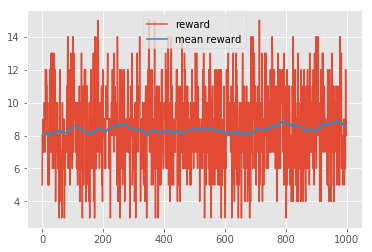

CPU times: user 18.6 s, sys: 465 ms, total: 19.1 s
Wall time: 19.3 s


In [29]:
%%time
Q = np.random.random_sample((env.observation_space.n, env.action_space.n))

def act(state, eps):
    if random.random() < eps:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state])

def update(state, action, next_state, reward, eps, lrate=0.75, gamma=0.9):
    qa = Q[next_state, next_action]
    q = Q[state, action]
    Q[state, action] += lrate * (reward + gamma * qa - q)
    
tr = []
ef = 1e-4
for i in range(40000):
    state, done = env.reset(), False
    tr.append(0)
    eps = max(ef, np.exp(np.log(ef) * i / 35000))
    action = act(state, eps)
    while not done:
        next_state, reward, done, _ = env.step(action)
        next_action = act(next_state, eps)
        update(state, action, next_state, reward, next_action, lrate=0.3, gamma=0.9)
        state, action = next_state, next_action
        tr[-1] += reward

plot.plot(tr[-1000:], label = 'reward')
plot.plot(wmean(tr, 100)[-1000:], label='mean reward')
plot.legend()
plot.show();